In [1]:
# test
import torch
import numpy as np
from spectralnet import SpectralNet

In [2]:
bbox_path = "/home/guests/oleksandra_tmenova/test/project/thesis-codebase/deep-spectral-segmentation/outputs/liver_mixed_val_mini/exp_clustering_sweep/2023-11-07/12-55-48/seg5_clust5_norm-imagenet_prepr-False_dino1_clusterkmeans/multi_region_bboxes/laplacian/bbox_features.pth"

In [3]:
bbox_list = torch.load(bbox_path)
total_num_boxes = sum(len(d['bboxes']) for d in bbox_list)
print(f'Loaded bounding box list. There are {total_num_boxes} total bounding boxes with features.')


Loaded bounding box list. There are 40 total bounding boxes with features.


In [4]:
# Loop over boxes and stack features with PyTorch, because Numpy is too slow
print(f'Stacking and normalizing features')
all_features = torch.cat([bbox_dict['features'] for bbox_dict in bbox_list], dim=0)  # (numBbox, D)


Stacking and normalizing features


In [5]:
all_features_norm = all_features / torch.norm(all_features, dim=-1, keepdim=True)  # (numBbox, D)f
type(all_features_norm), all_features_norm.shape

(torch.Tensor, torch.Size([40, 384]))

In [6]:
import umap

/home/guests/oleksandra_tmenova/test/project/.venv-p311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
mapper = umap.UMAP().fit(all_features_norm)

In [9]:
import umap.plot

/home/guests/oleksandra_tmenova/test/project/.venv-p311/lib/python3.11/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


/home/guests/oleksandra_tmenova/test/project/.venv-p311/lib/python3.11/site-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

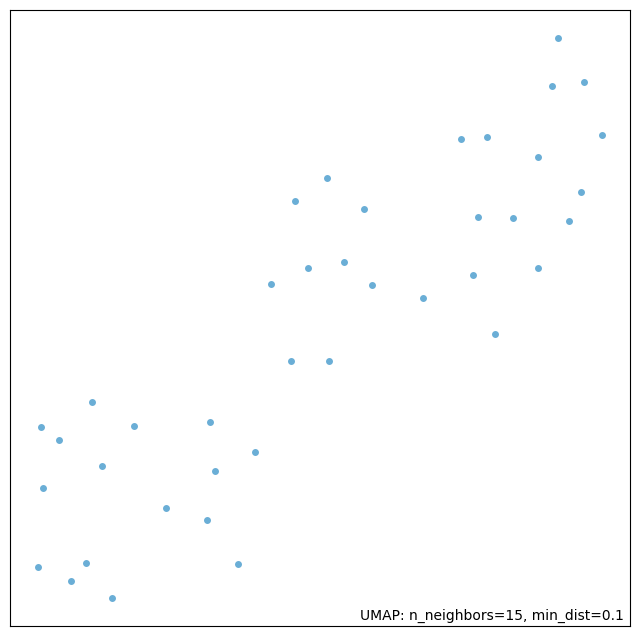

In [10]:
umap.plot.points(mapper)

/home/guests/oleksandra_tmenova/test/project/.venv-p311/lib/python3.11/site-packages/datashader/transfer_functions/__init__.py:326: RuntimeWarning: invalid value encountered in divide
  scaled_data = (data - span[0])/(span[1] - span[0])


<Axes: >

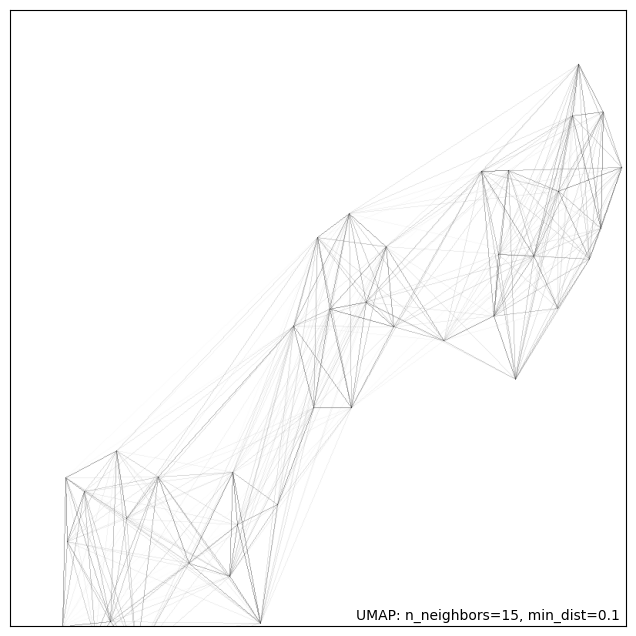

In [11]:
umap.plot.connectivity(mapper, show_points=True)

In [13]:
# kemans
from sklearn.cluster import KMeans, MiniBatchKMeans

all_features_norm_numpy = all_features_norm.detach().numpy()
kmeans = MiniBatchKMeans(n_clusters=6, batch_size=10, max_iter=5000, random_state=1)
clusters2 = kmeans.fit_predict(all_features_norm_numpy)
_indices2, _counts2 = np.unique(clusters2, return_counts=True)
print(f'Cluster indices: {_indices2.tolist()}')
print(f'Cluster counts: {_counts2.tolist()}')

/home/guests/oleksandra_tmenova/test/project/.venv-p311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Cluster indices: [0, 1, 2, 3, 4, 5]
Cluster counts: [7, 10, 2, 7, 5, 9]


<Axes: >

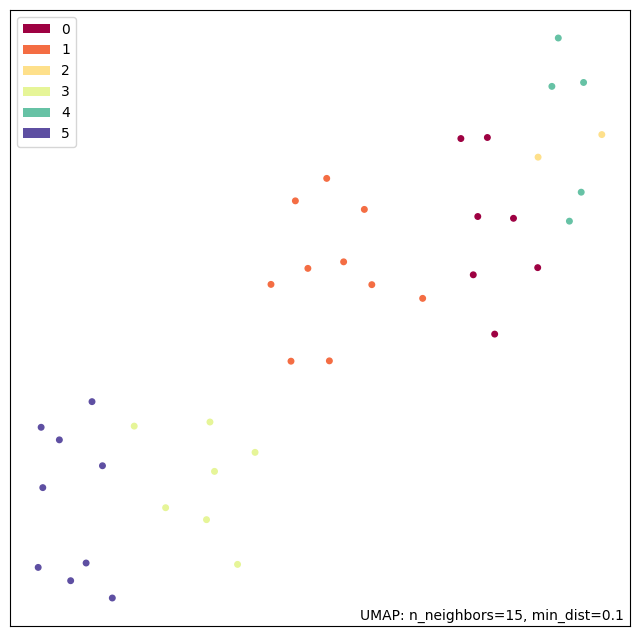

In [14]:
umap.plot.points(mapper, labels = clusters2)

<Axes: >

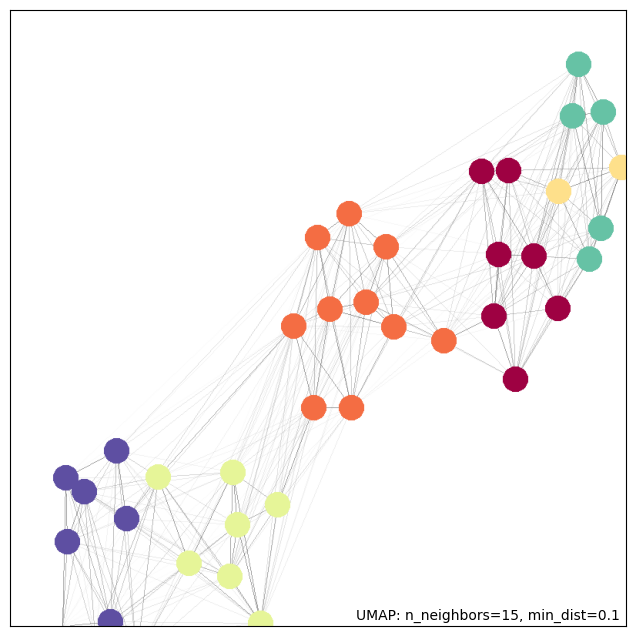

In [17]:
umap.plot.connectivity(mapper, show_points=True, labels = clusters2)

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

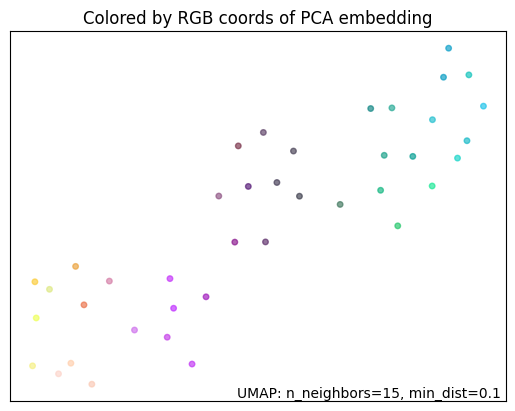

In [18]:
umap.plot.diagnostic(mapper, diagnostic_type='pca')

/home/guests/oleksandra_tmenova/test/project/.venv-p311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: title={'center': 'Colored by RGB coords of Vector Quantization'}>

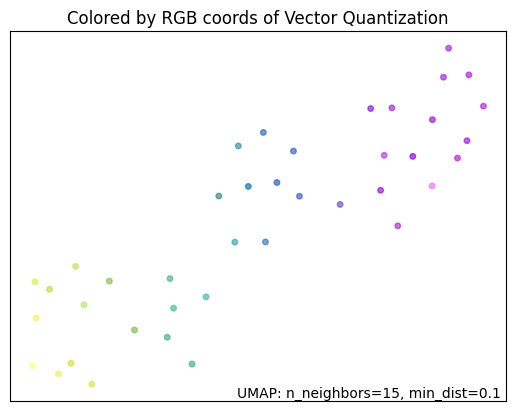

In [19]:
umap.plot.diagnostic(mapper, diagnostic_type='vq')

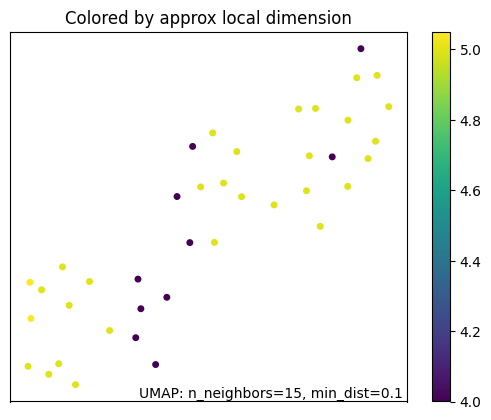

In [20]:
local_dims = umap.plot.diagnostic(mapper, diagnostic_type='local_dim')

In [21]:
spectralnet = SpectralNet(n_clusters=6,
                        should_use_siamese=True,
                        should_use_ae = True)
spectralnet.fit(all_features_norm)
clusters4 = spectralnet.predict(all_features_norm)
_indices4, _counts4 = np.unique(clusters4, return_counts=True)
print(f'Cluster indices: {_indices4.tolist()}')
print(f'Cluster counts: {_counts4.tolist()}')

Training Autoencoder:


Train Loss: 0.0005465, Valid Loss: 0.0005943, LR: 0.001000: 100%|██████████| 40/40 [00:19<00:00,  2.02it/s]


Embedding data ...
Training Siamese Network:


Train Loss: 0.0232278, Valid Loss: 0.0941138, LR: 0.000010: 100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


Training SpectralNet:


Train Loss: 84.6440125, Valid Loss: 10.8053293, LR: 0.001000: 100%|██████████| 30/30 [00:20<00:00,  1.49it/s] 


Cluster indices: [0, 1, 2, 3, 4, 5]
Cluster counts: [11, 13, 11, 1, 1, 3]


<Axes: >

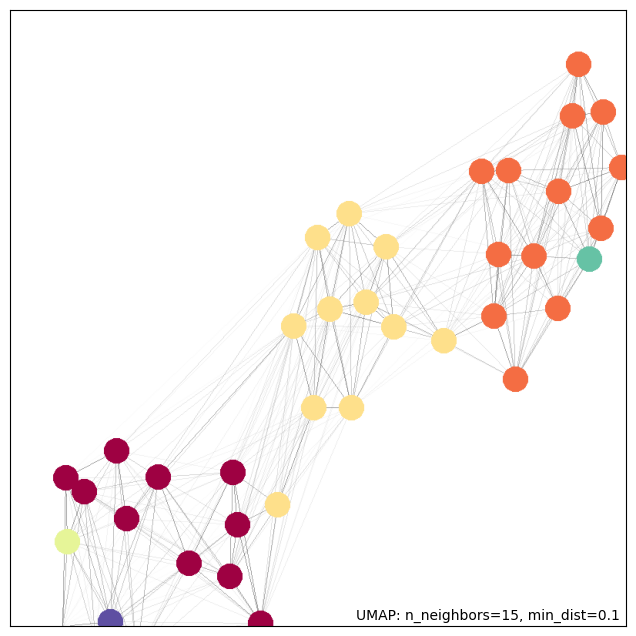

In [22]:
umap.plot.connectivity(mapper, show_points=True, labels = clusters4)